# 🔗 Intelligent Supply Chain Optimization System
## Notebook 05 — XGBoost Demand Forecasting Model

**Project:** Intelligent Supply Chain Optimization System  
**Phase:** Machine Learning — Feature-Based Forecasting  
**Input:** `features_xgboost.csv` (output from Notebook 03)  
**Objective:** Build, tune and evaluate an XGBoost model that captures feature-driven demand patterns.

---

### 📋 What This Notebook Does
1. Load XGBoost-ready dataset
2. Chronological train/val/test split
3. Train baseline XGBoost (default params)
4. Hyperparameter tuning with RandomizedSearchCV
5. Train final tuned XGBoost model
6. Evaluate on test set (MAE, RMSE, MAPE, R²) vs baseline
7. Feature importance analysis (3 methods)
8. Residual & error analysis
9. Per-SKU performance
10. Save model + predictions + metrics

---

## 📦 Section 1: Imports & Configuration

In [1]:
# ─────────────────────────────────────────────────────────────
# SECTION 1: IMPORTS & CONFIG
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import json
import joblib

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rcParams['figure.figsize']    = (14, 5)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titleweight']  = 'bold'
sns.set_palette('muted')

SEED = 42
np.random.seed(SEED)

# ── Split ratios (must match Notebook 04) ──
TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15

print('✅ Imports loaded.')

✅ Imports loaded.


---
## 📂 Section 2: Load Data & Define Features

In [2]:
# ─────────────────────────────────────────────────────────────
# SECTION 2: LOAD DATA
# ─────────────────────────────────────────────────────────────

df = pd.read_csv('features_xgboost.csv', parse_dates=['Date'])
df = df.sort_values(['SKU_ID', 'Warehouse_ID', 'Date']).reset_index(drop=True)

print(f'✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'   Date range  : {df["Date"].min().date()} → {df["Date"].max().date()}')
print()

TARGET = 'Units_Sold'

# ── Drop non-feature columns ──
DROP_COLS = ['Date', 'SKU_ID', 'Warehouse_ID', TARGET]
FEATURE_COLS = [c for c in df.columns if c not in DROP_COLS]

print(f'   Total features  : {len(FEATURE_COLS)}')
print(f'   Target variable : {TARGET}')
print(f'\n   Feature list:')
for i, f in enumerate(FEATURE_COLS, 1):
    print(f'   {i:>3}. {f}')

✅ Dataset loaded: 91,250 rows × 79 columns
   Date range  : 2024-01-01 → 2024-12-30

   Total features  : 75
   Target variable : Units_Sold

   Feature list:
     1. SKU_ID_Enc
     2. Warehouse_ID_Enc
     3. Supplier_ID_Enc
     4. Region_Enc
     5. Year
     6. Month
     7. Day
     8. DayOfWeek
     9. DayOfYear
    10. WeekOfYear
    11. Quarter
    12. Is_Weekend
    13. Is_MonthEnd
    14. Is_MonthStart
    15. Is_QuarterEnd
    16. Month_sin
    17. Month_cos
    18. DayOfWeek_sin
    19. DayOfWeek_cos
    20. DayOfYear_sin
    21. DayOfYear_cos
    22. WeekOfYear_sin
    23. WeekOfYear_cos
    24. Units_Sold_Lag_1
    25. Units_Sold_Lag_2
    26. Units_Sold_Lag_3
    27. Units_Sold_Lag_7
    28. Units_Sold_Lag_14
    29. Units_Sold_Lag_21
    30. Units_Sold_Lag_28
    31. Units_Sold_Lag_30
    32. Inventory_Lag_1
    33. Inventory_Lag_7
    34. Promo_Lag_1
    35. Promo_Lag_3
    36. Promo_Lag_7
    37. Rolling_Mean_7d
    38. Rolling_Mean_14d
    39. Rolling_Mean_30d
    4

---
## ✂️ Section 3: Chronological Train / Val / Test Split

In [3]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: CHRONOLOGICAL SPLIT
# ─────────────────────────────────────────────────────────────
# XGBoost does not use sequences — it works on flat rows.
# We still split chronologically to respect time-series order
# and prevent future data leaking into training.
# ─────────────────────────────────────────────────────────────

unique_dates  = sorted(df['Date'].unique())
n_dates       = len(unique_dates)
train_end_idx = int(n_dates * TRAIN_SPLIT)
val_end_idx   = int(n_dates * (TRAIN_SPLIT + VAL_SPLIT))

train_end_date = unique_dates[train_end_idx]
val_end_date   = unique_dates[val_end_idx]

train_df = df[df['Date'] <= train_end_date].copy()
val_df   = df[(df['Date'] > train_end_date) & (df['Date'] <= val_end_date)].copy()
test_df  = df[df['Date'] > val_end_date].copy()

X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET]
X_val,   y_val   = val_df[FEATURE_COLS],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURE_COLS],  test_df[TARGET]

print(f'  Training   : up to {pd.Timestamp(train_end_date).date()}  →  {len(train_df):,} rows')
print(f'  Validation : up to {pd.Timestamp(val_end_date).date()}    →  {len(val_df):,} rows')
print(f'  Test       : after {pd.Timestamp(val_end_date).date()}    →  {len(test_df):,} rows')
print()
print(f'  X_train : {X_train.shape}')
print(f'  X_val   : {X_val.shape}')
print(f'  X_test  : {X_test.shape}')

  Training   : up to 2024-09-12  →  64,000 rows
  Validation : up to 2024-11-06    →  13,750 rows
  Test       : after 2024-11-06    →  13,500 rows

  X_train : (64000, 75)
  X_val   : (13750, 75)
  X_test  : (13500, 75)


---
## 🌱 Section 4: Train Baseline XGBoost (Default Params)

In [4]:
# ─────────────────────────────────────────────────────────────
# SECTION 4: BASELINE XGBOOST
# ─────────────────────────────────────────────────────────────
# We first train with default params to establish an XGBoost
# baseline before hyperparameter tuning.
# ─────────────────────────────────────────────────────────────

xgb_base = XGBRegressor(
    n_estimators     = 300,
    learning_rate    = 0.1,
    max_depth        = 6,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    random_state     = SEED,
    n_jobs           = -1,
    verbosity        = 0
)

xgb_base.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred_base = xgb_base.predict(X_test)
y_pred_base = np.clip(y_pred_base, 0, None)

base_xgb_mae  = mean_absolute_error(y_test, y_pred_base)
base_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
base_xgb_mape = np.mean(np.abs((y_test - y_pred_base) /
                                 np.where(y_test == 0, 1, y_test))) * 100
base_xgb_r2   = 1 - (np.sum((y_test - y_pred_base)**2) /
                       np.sum((y_test - y_test.mean())**2))

print('── Baseline XGBoost (default params) ──')
print(f'  MAE   : {base_xgb_mae:.4f}')
print(f'  RMSE  : {base_xgb_rmse:.4f}')
print(f'  MAPE  : {base_xgb_mape:.2f}%')
print(f'  R²    : {base_xgb_r2:.4f}')
print('\n  ➡️  Now tuning hyperparameters to improve further...')

── Baseline XGBoost (default params) ──
  MAE   : 0.0872
  RMSE  : 0.1638
  MAPE  : 0.80%
  R²    : 0.9992

  ➡️  Now tuning hyperparameters to improve further...


---
## 🔧 Section 5: Hyperparameter Tuning (RandomizedSearchCV)

In [5]:
# ─────────────────────────────────────────────────────────────
# SECTION 5: HYPERPARAMETER TUNING
# ─────────────────────────────────────────────────────────────
# We use RandomizedSearchCV with TimeSeriesSplit to respect
# temporal ordering during cross-validation.
# ─────────────────────────────────────────────────────────────

param_dist = {
    'n_estimators'      : [200, 300, 500, 700],
    'max_depth'         : [3, 4, 5, 6, 7, 8],
    'learning_rate'     : [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample'         : [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree'  : [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_child_weight'  : [1, 3, 5, 7],
    'gamma'             : [0, 0.1, 0.2, 0.3],
    'reg_alpha'         : [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda'        : [0.5, 1.0, 1.5, 2.0]
}

# TimeSeriesSplit: preserves temporal order in CV folds
tscv = TimeSeriesSplit(n_splits=3)

xgb_search = RandomizedSearchCV(
    estimator  = XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    param_distributions = param_dist,
    n_iter     = 40,           # number of random combinations to try
    scoring    = 'neg_mean_absolute_error',
    cv         = tscv,
    verbose    = 1,
    n_jobs     = -1,
    random_state = SEED
)

# Fit on train + val combined for tuning
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

print('🔧 Running RandomizedSearchCV (40 iterations × 3 folds = 120 fits)...')
print('   This will take a few minutes.\n')

xgb_search.fit(X_tune, y_tune)

best_params = xgb_search.best_params_
print(f'\n✅ Best parameters found:')
for k, v in best_params.items():
    print(f'   {k:<25} : {v}')
print(f'\n   Best CV MAE : {-xgb_search.best_score_:.4f}')

🔧 Running RandomizedSearchCV (40 iterations × 3 folds = 120 fits)...
   This will take a few minutes.

Fitting 3 folds for each of 40 candidates, totalling 120 fits

✅ Best parameters found:
   subsample                 : 0.9
   reg_lambda                : 0.5
   reg_alpha                 : 0.1
   n_estimators              : 300
   min_child_weight          : 7
   max_depth                 : 5
   learning_rate             : 0.1
   gamma                     : 0
   colsample_bytree          : 0.9

   Best CV MAE : 0.0889


---
## 🏆 Section 6: Train Final Tuned XGBoost Model

In [6]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: FINAL MODEL TRAINING
# ─────────────────────────────────────────────────────────────
# Train the tuned model with early stopping on val set.
# ─────────────────────────────────────────────────────────────

xgb_final = XGBRegressor(
    **best_params,
    random_state = SEED,
    n_jobs       = -1,
    verbosity    = 0,
    early_stopping_rounds = 20
)

xgb_final.fit(
    X_train, y_train,
    eval_set   = [(X_train, y_train), (X_val, y_val)],
    verbose    = 50
)

print(f'\n✅ Final model trained.')
print(f'   Best iteration : {xgb_final.best_iteration}')

[0]	validation_0-rmse:7.62163	validation_1-rmse:12.46619
[50]	validation_0-rmse:0.27540	validation_1-rmse:0.30609
[100]	validation_0-rmse:0.18624	validation_1-rmse:0.20148
[150]	validation_0-rmse:0.15087	validation_1-rmse:0.17609
[200]	validation_0-rmse:0.12943	validation_1-rmse:0.16621
[250]	validation_0-rmse:0.11762	validation_1-rmse:0.16062
[299]	validation_0-rmse:0.10717	validation_1-rmse:0.15614

✅ Final model trained.
   Best iteration : 299


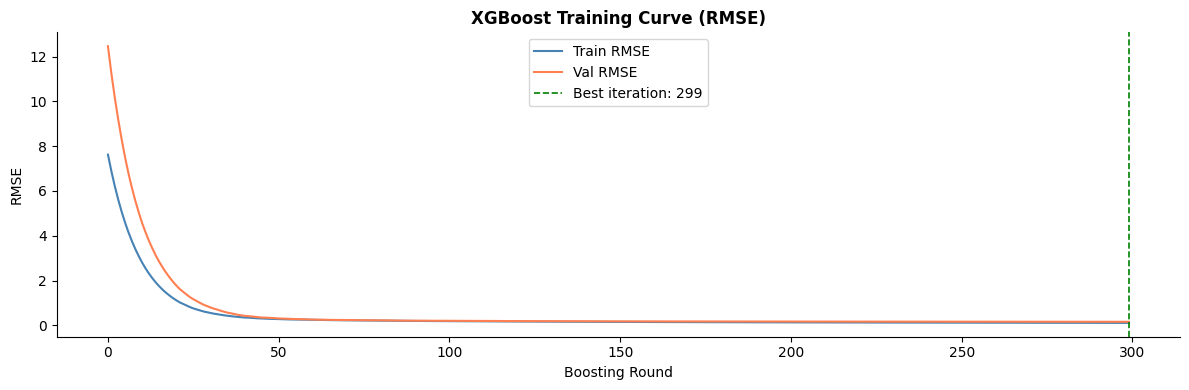

In [7]:
# ── Plot training curve ──
results     = xgb_final.evals_result()
train_rmse  = results['validation_0']['rmse']
val_rmse    = results['validation_1']['rmse']

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_rmse, label='Train RMSE', color='steelblue', linewidth=1.5)
ax.plot(val_rmse,   label='Val RMSE',   color='coral',     linewidth=1.5)
ax.axvline(xgb_final.best_iteration, color='green', linestyle='--', linewidth=1.2,
           label=f'Best iteration: {xgb_final.best_iteration}')
ax.set_title('XGBoost Training Curve (RMSE)')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('RMSE')
ax.legend()
plt.tight_layout()
plt.show()

---
## 📏 Section 7: Evaluate on Test Set

In [8]:
# ─────────────────────────────────────────────────────────────
# SECTION 7: TEST SET EVALUATION
# ─────────────────────────────────────────────────────────────

y_pred_xgb = xgb_final.predict(X_test)
y_pred_xgb = np.clip(y_pred_xgb, 0, None)

# ── XGBoost Tuned metrics ──
xgb_mae  = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mape = np.mean(np.abs((y_test - y_pred_xgb) /
                            np.where(y_test == 0, 1, y_test))) * 100
xgb_r2   = 1 - (np.sum((y_test - y_pred_xgb)**2) /
                  np.sum((y_test - y_test.mean())**2))

# ── Naive baseline (Demand_Forecast column) ──
y_baseline = test_df['Demand_Forecast'].values
b_mae  = mean_absolute_error(y_test, y_baseline)
b_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
b_mape = np.mean(np.abs((y_test - y_baseline) /
                          np.where(y_test == 0, 1, y_test))) * 100
b_r2   = 1 - (np.sum((y_test - y_baseline)**2) /
               np.sum((y_test - y_test.mean())**2))

print('=' * 68)
print('  XGBOOST MODEL — TEST SET PERFORMANCE')
print('=' * 68)
print(f'  {"Metric":<8}  {"XGB Tuned":>12}  {"XGB Default":>12}  {"Baseline":>12}')
print(f'  {"-"*8}  {"-"*12}  {"-"*12}  {"-"*12}')
print(f'  {"MAE":<8}  {xgb_mae:>12.4f}  {base_xgb_mae:>12.4f}  {b_mae:>12.4f}')
print(f'  {"RMSE":<8}  {xgb_rmse:>12.4f}  {base_xgb_rmse:>12.4f}  {b_rmse:>12.4f}')
print(f'  {"MAPE":<8}  {xgb_mape:>11.2f}%  {base_xgb_mape:>11.2f}%  {b_mape:>11.2f}%')
print(f'  {"R²":<8}  {xgb_r2:>12.4f}  {base_xgb_r2:>12.4f}  {b_r2:>12.4f}')
print('=' * 68)

improvements = {
    'MAE'  : (b_mae  - xgb_mae)  / b_mae  * 100,
    'RMSE' : (b_rmse - xgb_rmse) / b_rmse * 100,
    'MAPE' : (b_mape - xgb_mape) / b_mape * 100,
    'R²'   : xgb_r2 - b_r2
}
print()
print('  Improvement vs Naive Baseline:')
for m, imp in improvements.items():
    icon = '✅' if imp > 0 else '❌'
    unit = '' if m == 'R²' else '%'
    print(f'    {icon}  {m:<6} : {imp:+.2f}{unit}')

  XGBOOST MODEL — TEST SET PERFORMANCE
  Metric       XGB Tuned   XGB Default      Baseline
  --------  ------------  ------------  ------------
  MAE             0.0915        0.0872        2.3830
  RMSE            0.1577        0.1638        2.9894
  MAPE             0.87%         0.80%        18.55%
  R²              0.9993        0.9992        0.7367

  Improvement vs Naive Baseline:
    ✅  MAE    : +96.16%
    ✅  RMSE   : +94.73%
    ✅  MAPE   : +95.31%
    ✅  R²     : +0.26


---
## 🌟 Section 8: Feature Importance Analysis (3 Methods)

In [9]:
# ─────────────────────────────────────────────────────────────
# SECTION 8: FEATURE IMPORTANCE — 3 METHODS
#
#  1. Gain (built-in XGBoost) — average gain per split
#  2. Weight (built-in XGBoost) — number of times used in splits
#  3. Permutation Importance — model-agnostic, most reliable
# ─────────────────────────────────────────────────────────────

# ── Method 1 & 2: XGBoost built-in ──
importance_gain   = xgb_final.get_booster().get_score(importance_type='gain')
importance_weight = xgb_final.get_booster().get_score(importance_type='weight')

imp_gain_df   = pd.DataFrame(importance_gain.items(),   columns=['Feature', 'Gain']  ).sort_values('Gain',   ascending=False)
imp_weight_df = pd.DataFrame(importance_weight.items(), columns=['Feature', 'Weight']).sort_values('Weight', ascending=False)

print('── Top 15 Features by Gain ──')
print(imp_gain_df.head(15).to_string(index=False))

── Top 15 Features by Gain ──
             Feature      Gain
     Demand_Forecast 7573.6709
     Inventory_Delta 5807.4634
       DayOfYear_sin 4968.0693
      Order_Quantity  703.3975
      Forecast_Error  357.0303
Promo_x_RollingMean7  122.0057
       DayOfYear_cos  111.1788
  Forecast_Error_Abs   78.1918
     Rolling_Max_30d   75.7174
           DayOfYear   56.3656
     Rolling_Max_14d   41.6644
             EWMA_7d   35.9499
      WeekOfYear_sin   14.0625
    Units_Sold_Lag_1   11.3035
            EWMA_14d    9.1503


In [10]:
# ── Method 3: Permutation Importance (on val set, faster than test) ──
print('Computing permutation importance (this takes ~1 min)...')

perm_imp = permutation_importance(
    xgb_final, X_val, y_val,
    n_repeats   = 10,
    random_state= SEED,
    scoring     = 'neg_mean_absolute_error',
    n_jobs      = -1
)

perm_df = pd.DataFrame({
    'Feature'      : FEATURE_COLS,
    'Importance'   : perm_imp.importances_mean,
    'Std'          : perm_imp.importances_std
}).sort_values('Importance', ascending=False)

print('\n── Top 15 Features by Permutation Importance ──')
print(perm_df.head(15).to_string(index=False))

Computing permutation importance (this takes ~1 min)...

── Top 15 Features by Permutation Importance ──
           Feature  Importance    Std
   Inventory_Delta      3.6553 0.0103
   Demand_Forecast      2.2329 0.0135
    Forecast_Error      0.7310 0.0056
Forecast_Error_Abs      0.0768 0.0010
    Order_Quantity      0.0338 0.0006
   Inventory_Lag_1      0.0004 0.0001
     Reorder_Point      0.0001 0.0000
   Inventory_Level      0.0001 0.0000
   Demand_Momentum      0.0000 0.0000
         Stock_Gap      0.0000 0.0000
   Rolling_Min_30d      0.0000 0.0000
   Rolling_Max_30d      0.0000 0.0001
 Units_Sold_Lag_30      0.0000 0.0000
 Profit_Margin_Pct      0.0000 0.0000
   Rolling_Std_30d      0.0000 0.0000


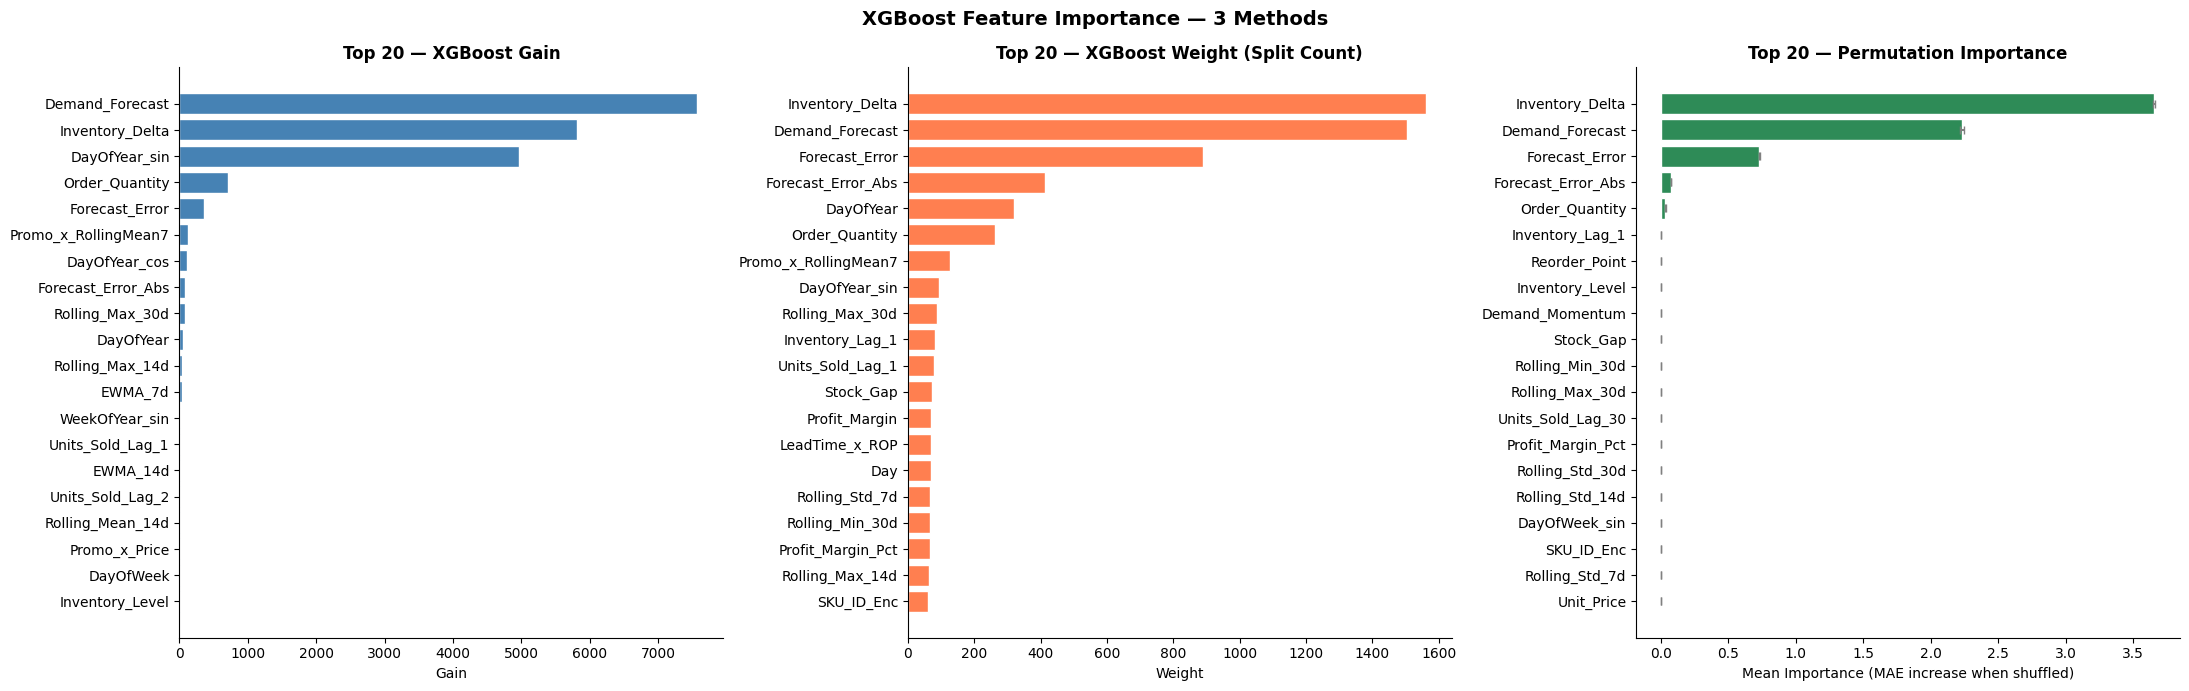

In [11]:
# ── Plot all 3 importance methods ──
top_n = 20
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Gain
top_gain = imp_gain_df.head(top_n)
axes[0].barh(top_gain['Feature'][::-1], top_gain['Gain'][::-1],
             color='steelblue', edgecolor='white')
axes[0].set_title(f'Top {top_n} — XGBoost Gain')
axes[0].set_xlabel('Gain')

# Weight
top_weight = imp_weight_df.head(top_n)
axes[1].barh(top_weight['Feature'][::-1], top_weight['Weight'][::-1],
             color='coral', edgecolor='white')
axes[1].set_title(f'Top {top_n} — XGBoost Weight (Split Count)')
axes[1].set_xlabel('Weight')

# Permutation
top_perm = perm_df.head(top_n)
axes[2].barh(top_perm['Feature'][::-1], top_perm['Importance'][::-1],
             xerr=top_perm['Std'][::-1],
             color='seagreen', edgecolor='white', ecolor='grey', capsize=3)
axes[2].set_title(f'Top {top_n} — Permutation Importance')
axes[2].set_xlabel('Mean Importance (MAE increase when shuffled)')

plt.suptitle('XGBoost Feature Importance — 3 Methods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 📉 Section 9: Residual & Error Analysis

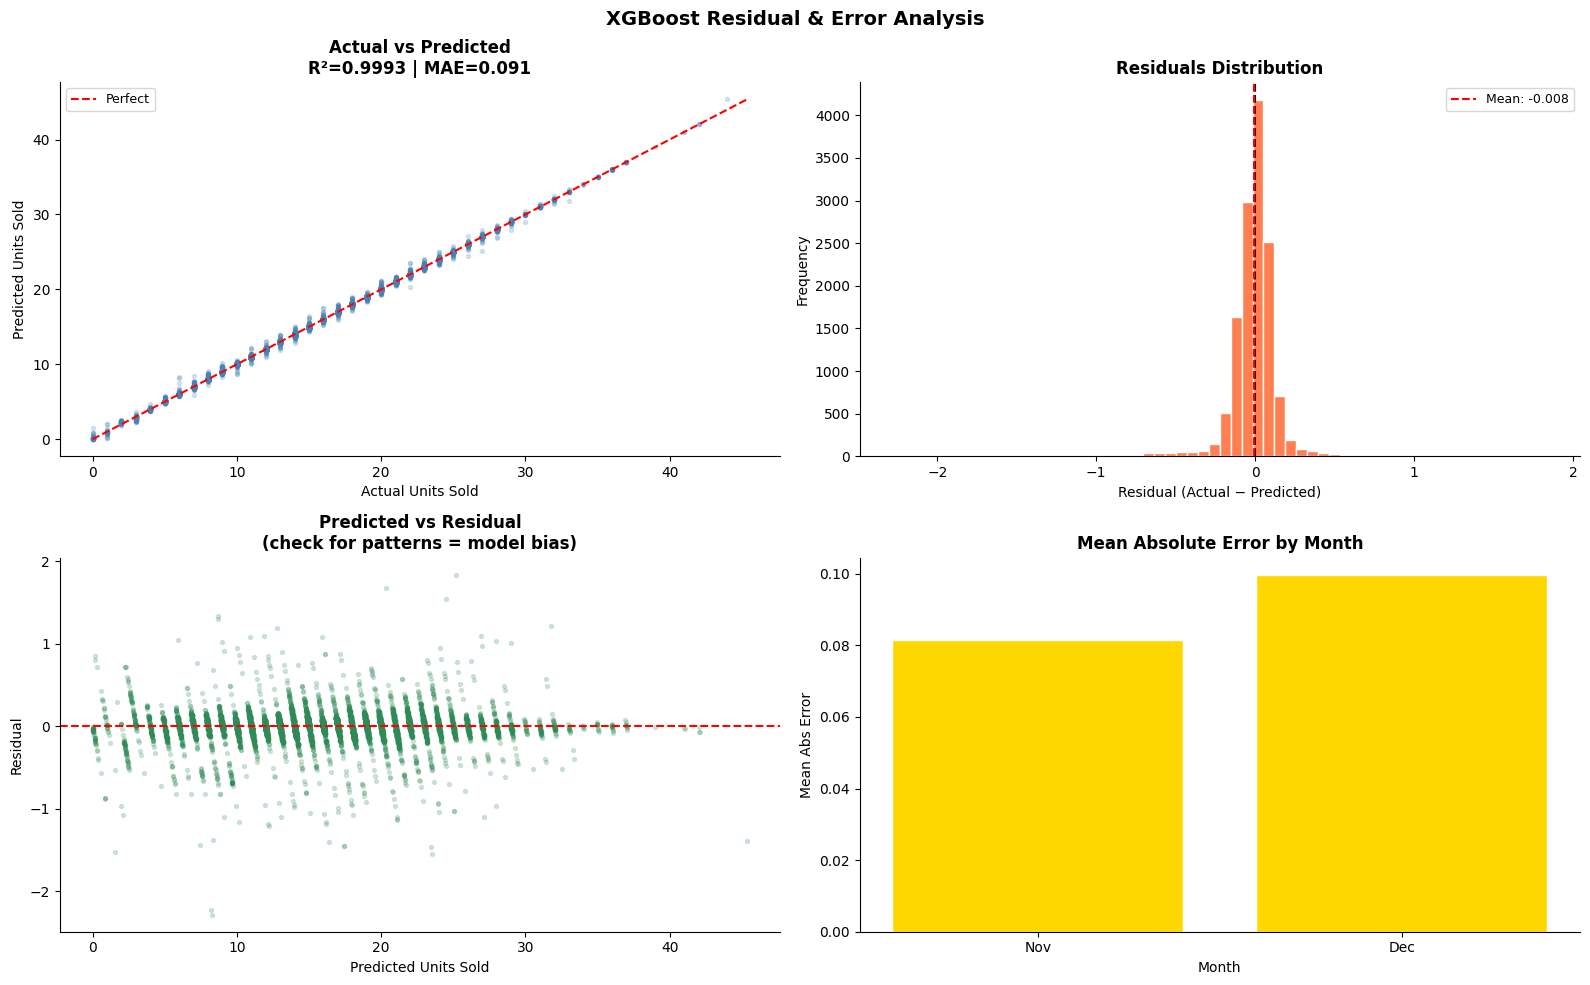

In [12]:
# ─────────────────────────────────────────────────────────────
# SECTION 9: RESIDUAL ANALYSIS
# ─────────────────────────────────────────────────────────────

residuals   = y_test.values - y_pred_xgb
abs_errors  = np.abs(residuals)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ── 1. Actual vs Predicted ──
axes[0,0].scatter(y_test, y_pred_xgb, alpha=0.2, s=8, color='steelblue')
lim = [0, max(y_test.max(), y_pred_xgb.max())]
axes[0,0].plot(lim, lim, 'r--', linewidth=1.5, label='Perfect')
axes[0,0].set_title(f'Actual vs Predicted\nR²={xgb_r2:.4f} | MAE={xgb_mae:.3f}')
axes[0,0].set_xlabel('Actual Units Sold')
axes[0,0].set_ylabel('Predicted Units Sold')
axes[0,0].legend(fontsize=9)

# ── 2. Residuals distribution ──
axes[0,1].hist(residuals, bins=60, color='coral', edgecolor='white')
axes[0,1].axvline(0, color='black', linestyle='--', linewidth=1.5)
axes[0,1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=1.5,
                  label=f'Mean: {residuals.mean():.3f}')
axes[0,1].set_title('Residuals Distribution')
axes[0,1].set_xlabel('Residual (Actual − Predicted)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend(fontsize=9)

# ── 3. Predicted vs Residual (heteroscedasticity check) ──
axes[1,0].scatter(y_pred_xgb, residuals, alpha=0.2, s=8, color='seagreen')
axes[1,0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1,0].set_title('Predicted vs Residual\n(check for patterns = model bias)')
axes[1,0].set_xlabel('Predicted Units Sold')
axes[1,0].set_ylabel('Residual')

# ── 4. Absolute error by month ──
test_df_eval = test_df.copy()
test_df_eval['Abs_Error'] = abs_errors
test_df_eval['Month_Name'] = test_df_eval['Date'].dt.strftime('%b')
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
monthly_err = (test_df_eval.groupby('Month_Name')['Abs_Error']
                            .mean()
                            .reindex([m for m in month_order
                                      if m in test_df_eval['Month_Name'].unique()]))
axes[1,1].bar(monthly_err.index, monthly_err.values, color='gold', edgecolor='white')
axes[1,1].set_title('Mean Absolute Error by Month')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Mean Abs Error')

plt.suptitle('XGBoost Residual & Error Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🔍 Section 10: Per-SKU Performance

In [13]:
# ─────────────────────────────────────────────────────────────
# SECTION 10: PER-SKU PERFORMANCE
# ─────────────────────────────────────────────────────────────

test_df_eval['XGB_Pred'] = y_pred_xgb

sku_results = []
for (sku, wh), grp in test_df_eval.groupby(['SKU_ID', 'Warehouse_ID']):
    if len(grp) < 5:
        continue
    act  = grp[TARGET].values
    pred = grp['XGB_Pred'].values
    denom = np.where(act == 0, 1, act)
    sku_results.append({
        'SKU_ID'      : sku,
        'Warehouse_ID': wh,
        'MAE'         : round(mean_absolute_error(act, pred), 3),
        'RMSE'        : round(np.sqrt(mean_squared_error(act, pred)), 3),
        'MAPE'        : round(np.mean(np.abs((act - pred) / denom)) * 100, 2),
        'Samples'     : len(grp)
    })

sku_perf_xgb = pd.DataFrame(sku_results).sort_values('MAPE')

print('── Top 10 Best SKUs (lowest MAPE) ──')
print(sku_perf_xgb.head(10).to_string(index=False))
print()
print('── Top 10 Worst SKUs (highest MAPE) ──')
print(sku_perf_xgb.tail(10).to_string(index=False))

── Top 10 Best SKUs (lowest MAPE) ──
SKU_ID Warehouse_ID    MAE   RMSE   MAPE  Samples
SKU_50         WH_3 0.0630 0.0760 0.4200       54
 SKU_8         WH_3 0.0650 0.0890 0.4300       54
 SKU_8         WH_1 0.0700 0.1100 0.4500       54
SKU_14         WH_4 0.0630 0.0870 0.4500       54
SKU_50         WH_4 0.0740 0.1560 0.4600       54
SKU_43         WH_4 0.0710 0.0940 0.4600       54
SKU_23         WH_3 0.0680 0.0920 0.4600       54
SKU_30         WH_4 0.0670 0.0840 0.4700       54
SKU_24         WH_1 0.0700 0.1030 0.4700       54
 SKU_5         WH_5 0.0680 0.0850 0.4700       54

── Top 10 Worst SKUs (highest MAPE) ──
SKU_ID Warehouse_ID    MAE   RMSE   MAPE  Samples
SKU_36         WH_2 0.0930 0.1550 2.1200       54
SKU_42         WH_1 0.0910 0.1440 2.1300       54
SKU_48         WH_1 0.1080 0.1830 2.1900       54
SKU_30         WH_2 0.1040 0.1680 2.2900       54
SKU_13         WH_1 0.1070 0.1760 2.4400       54
SKU_28         WH_3 0.1140 0.2590 2.4500       54
SKU_14         WH_2 0.1

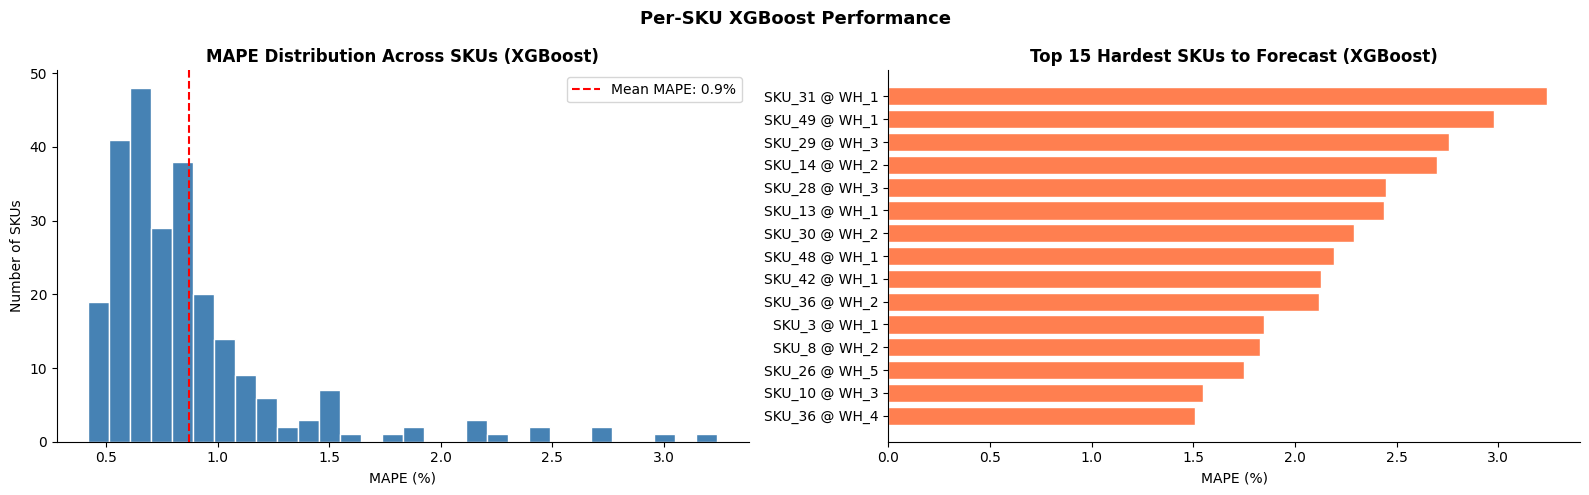

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# MAPE distribution
axes[0].hist(sku_perf_xgb['MAPE'], bins=30, color='steelblue', edgecolor='white')
axes[0].axvline(sku_perf_xgb['MAPE'].mean(), color='red', linestyle='--',
                label=f'Mean MAPE: {sku_perf_xgb["MAPE"].mean():.1f}%')
axes[0].set_title('MAPE Distribution Across SKUs (XGBoost)')
axes[0].set_xlabel('MAPE (%)')
axes[0].set_ylabel('Number of SKUs')
axes[0].legend()

# Worst 15 SKUs
worst15 = sku_perf_xgb.tail(15).sort_values('MAPE', ascending=True)
axes[1].barh(worst15['SKU_ID'] + ' @ ' + worst15['Warehouse_ID'],
             worst15['MAPE'], color='coral', edgecolor='white')
axes[1].set_title('Top 15 Hardest SKUs to Forecast (XGBoost)')
axes[1].set_xlabel('MAPE (%)')

plt.suptitle('Per-SKU XGBoost Performance', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 💾 Section 11: Save Model & Outputs

In [15]:
# ─────────────────────────────────────────────────────────────
# SECTION 11: SAVE OUTPUTS
# ─────────────────────────────────────────────────────────────

# ── Save model ──
joblib.dump(xgb_final, 'xgb_final_model.pkl')
print('✅ Model saved: xgb_final_model.pkl')

# ── Save test predictions ──
xgb_preds_df = test_df[['Date','SKU_ID','Warehouse_ID',TARGET,'Demand_Forecast']].copy()
xgb_preds_df['XGB_Pred'] = y_pred_xgb
xgb_preds_df.to_csv('xgb_test_predictions.csv', index=False)
print(f'✅ Test predictions saved: xgb_test_predictions.csv ({len(xgb_preds_df):,} rows)')

# ── Save metrics ──
xgb_metrics = {
    'MAE' : xgb_mae, 'RMSE': xgb_rmse,
    'MAPE': xgb_mape,'R2'  : xgb_r2
}
with open('xgb_metrics.json', 'w') as f:
    json.dump(xgb_metrics, f, indent=2)
print('✅ Metrics saved: xgb_metrics.json')

# ── Save feature importance ──
imp_gain_df.to_csv('xgb_feature_importance.csv', index=False)
perm_df.to_csv('xgb_permutation_importance.csv', index=False)
print('✅ Feature importances saved.')

# ── Save per-SKU performance ──
sku_perf_xgb.to_csv('xgb_sku_performance.csv', index=False)
print('✅ Per-SKU performance saved: xgb_sku_performance.csv')

# ── Save best params ──
with open('xgb_best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)
print('✅ Best hyperparameters saved: xgb_best_params.json')

print()
print('─' * 50)
print('  FINAL XGBoost SUMMARY')
print('─' * 50)
print(f'  MAE   : {xgb_mae:.4f}  (baseline: {b_mae:.4f})')
print(f'  RMSE  : {xgb_rmse:.4f}  (baseline: {b_rmse:.4f})')
print(f'  MAPE  : {xgb_mape:.2f}%   (baseline: {b_mape:.2f}%)')
print(f'  R²    : {xgb_r2:.4f}  (baseline: {b_r2:.4f})')
print('─' * 50)
print('\n   ➡️  Proceed to Notebook 06: Hybrid Model')

✅ Model saved: xgb_final_model.pkl
✅ Test predictions saved: xgb_test_predictions.csv (13,500 rows)
✅ Metrics saved: xgb_metrics.json
✅ Feature importances saved.
✅ Per-SKU performance saved: xgb_sku_performance.csv
✅ Best hyperparameters saved: xgb_best_params.json

──────────────────────────────────────────────────
  FINAL XGBoost SUMMARY
──────────────────────────────────────────────────
  MAE   : 0.0915  (baseline: 2.3830)
  RMSE  : 0.1577  (baseline: 2.9894)
  MAPE  : 0.87%   (baseline: 18.55%)
  R²    : 0.9993  (baseline: 0.7367)
──────────────────────────────────────────────────

   ➡️  Proceed to Notebook 06: Hybrid Model


---
## ✅ Notebook 05 Summary

| Step | Detail |
|---|---|
| Model | XGBoost Regressor |
| Tuning | RandomizedSearchCV (40 iter) + TimeSeriesSplit (3 folds) |
| Early Stopping | 20 rounds on validation set |
| Feature Importance | Gain, Weight, Permutation (3 methods) |
| Split | 70% Train / 15% Val / 15% Test (chronological) |
| Comparison | XGB Tuned vs XGB Default vs Naive Baseline |

**Outputs:**
- `xgb_final_model.pkl` — trained model
- `xgb_test_predictions.csv` — predictions with Date, SKU, Actual
- `xgb_metrics.json` — MAE, RMSE, MAPE, R²
- `xgb_feature_importance.csv` — gain-based importance
- `xgb_permutation_importance.csv` — permutation importance
- `xgb_sku_performance.csv` — per-SKU breakdown
- `xgb_best_params.json` — tuned hyperparameters

**➡️ Proceed to Notebook 06: Hybrid Model (LSTM + XGBoost Blending)**

---
*Intelligent Supply Chain Optimization System | Notebook 05 of 08*